In [1]:
import os, rpy2, scipy
import numpy as np
import pandas as pd
from qiime2 import Artifact
from qiime2.plugins.taxa.methods import collapse
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

datapath = '../Data'

In [2]:
##wu 
wu_df = pd.read_csv(os.path.join(datapath, 'dm/wudf.csv'), index_col=0)

## metadata
bombusMeta = pd.read_csv(os.path.join(datapath,'meta/bombusMeta.csv'))
bombusMeta.set_index('id', inplace = True)
bombusMeta['species'].replace({'fer':'bor'},
                             inplace = True)

## ASV table 
mt_99 = Artifact.load(os.path.join(datapath, 'qiime', 'mt_99.qza')).view(pd.DataFrame)
mt_99_norm = (mt_99.transpose()/mt_99.sum(axis =1)).transpose()

## Genus level 
taxa_6 = Artifact.load(os.path.join(datapath, 'qiime', 'mt_99_c6.qza')).view(pd.DataFrame)
taxa_6_norm = (taxa_6.transpose()/taxa_6.sum(axis =1)).transpose()


In [3]:
taxa_3 = collapse(Artifact.load(os.path.join(datapath, 'qiime', 'mt_99.qza')),
                  Artifact.load(os.path.join(datapath, 'qiime', 'taxonomy_99.qza')),
                  3).collapsed_table.view(pd.DataFrame)
taxa_3_norm = (taxa_3.transpose()/taxa_3.sum(axis =1)).transpose()

# Latent vs strong

divide sub 1K into upper and lower halves 
by site:
- proportion of infections
- proportion of strong sub

226 total sub-1K

In [68]:
threshold = bombusMeta[(bombusMeta['Positive'] ==0)&\
(bombusMeta['CBombiConc']>0)]['CBombiConc'].median()

bombusMeta['i_class'] = bombusMeta[['CBombiConc',
            'Positive']].apply(lambda x: 'negative' if x['CBombiConc']==0 else 'weak' if \
            x['CBombiConc']<3.2068474496093087 else 'strong' if x['Positive'] == 0 \
                else 'positive', axis =1)

In [89]:
iclass = pd.pivot(pd.DataFrame(bombusMeta.groupby('site_year')['Positive'\
    ].value_counts()).rename(columns = {'Positive':'count'}).reset_index(),
    index='site_year', columns='Positive',
    values='count').fillna(0).rename(columns = {0:'Negative',
    1:'Positive'}).join(pd.pivot(pd.DataFrame(bombusMeta.groupby('site_year')['i_class'].value_counts()\
    ).rename(columns = {'i_class':'count'}).reset_index(),
         index='site_year', columns='i_class', values='count').fillna(0))

In [141]:
iclass['total'] = iclass['Negative'] + iclass['Positive']
iclass['prop_pos'] = iclass['Positive'] / iclass['total']
iclass['prop_strong'] = iclass['strong'] /( iclass['strong'] + iclass['weak'])

In [142]:
iclass['pos_var'] = iclass['prop_pos'] * (1-iclass['prop_pos']) / iclass['total']
iclass['strong_var'] = iclass['prop_strong'] * (1-iclass['prop_strong']) / ( iclass['strong'] + iclass['weak'])


In [143]:
iclass['total_var'] = iclass['pos_var'] + iclass['strong_var']

In [167]:
regdf = iclass.dropna()[iclass.dropna()[['pos_var', 'strong_var']].min(axis=1) >0]
#regdf = regdf[regdf['total'] >5]

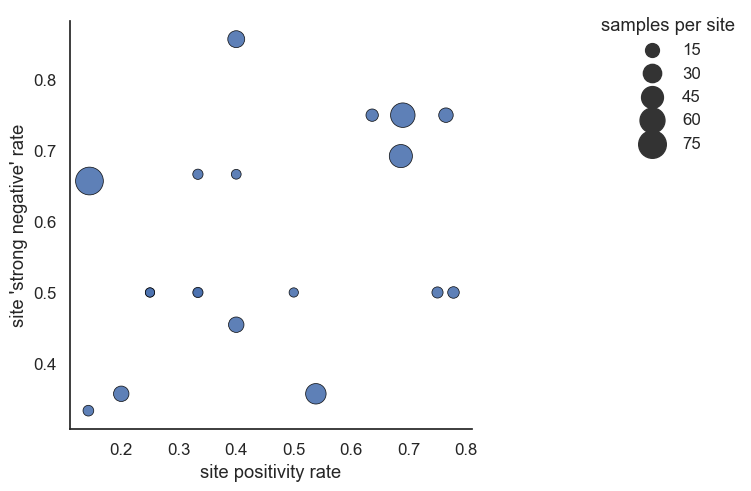

In [176]:
sns.set(font_scale = 1.1, style = 'white')
fig= sns.relplot(x="prop_pos", y="prop_strong",size="total",
            sizes=(40, 400), alpha=.9, edgecolor='black', data = regdf)

fig.legend.set_title('samples per site')
sns.move_legend(fig, loc='upper left', bbox_to_anchor = (1.05,1))
plt.xlabel('site positivity rate')
plt.ylabel("site 'strong negative' rate")

plt.show()
fig.savefig('figs/positive_vs_strong_neg.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')

In [169]:
smf.glm("prop_strong ~ prop_pos", data = regdf,
        family = sm.families.Poisson(),
       freq_weights = regdf['total_var']**(-1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            prop_strong   No. Observations:                   20
Model:                            GLM   Df Residuals:                   497.14
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -403.48
Date:                Sun, 29 Oct 2023   Deviance:                       20.281
Time:                        16:51:15   Pearson chi2:                     19.1
No. Iterations:                     4   Pseudo R-squ. (CS):            0.06705
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6230      0.123     -5.086      0.000      -0.863      -0.383
prop_pos       0.2959      0.251      1.179      0.239      -0.196       0.788
==============================================================================
"""

In [162]:
regdf[['prop_pos', 'prop_strong']].corr(method ='spearman')

,prop_pos,prop_strong
prop_pos,1.00000,0.41603
prop_strong,0.41603,1.00000


In [197]:
bysample = pd.merge(bombusMeta[(bombusMeta['Positive']==0) & (bombusMeta['CBombiConc']>0)][['site_year', 'CBombiConc']],
         iclass[['prop_pos','total', 'pos_var']], left_on = 'site_year',
         right_index=True)
bysample = bysample[bysample['pos_var'] >0]

In [ ]:
%load

In [206]:
%%R -i bysample
library(nlme)

w<-varFixed(~pos_var)

summary(lme(log(CBombiConc) ~ prop_pos, weights= w, data = bysample,
random = ~ 1|site_year))

Linear mixed-effects model fit by REML
  Data: bysample 
      AIC      BIC    logLik
  716.087 728.7462 -354.0435

Random effects:
 Formula: ~1 | site_year
        (Intercept) Residual
StdDev:   0.1976766 18.54013

Variance function:
 Structure: fixed weights
 Formula: ~pos_var 
Fixed effects:  log(CBombiConc) ~ prop_pos 
                Value Std.Error  DF  t-value p-value
(Intercept) 1.0061616 0.2635977 133 3.817035  0.0002
prop_pos    0.6921728 0.5532117  42 1.251190  0.2178
 Correlation: 
         (Intr)
prop_pos -0.856

Standardized Within-Group Residuals:
         Min           Q1          Med           Q3          Max 
-5.611533194 -0.385613080 -0.008205286  0.345050787  2.704783639 

Number of Observations: 177
Number of Groups: 44 


In [195]:
smf.wls("np.log(CBombiConc) ~ prop_pos", data = bysample[bysample['pos_var'] > 0],
       weights = bysample[bysample['pos_var'] > 0]['pos_var']**(-1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(CBombiConc)   R-squared:                       0.009
Model:                            WLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.507
Date:                Sun, 29 Oct 2023   Prob (F-statistic):              0.221
Time:                        16:59:57   Log-Likelihood:                -352.83
No. Observations:                 177   AIC:                             709.7
Df Residuals:                     175   BIC:                             716.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1473      0.162      7.087      0.000       0.828       1.467
prop_pos       0.5033      0.410      1.228      0.221      -0.306       1.312
==============================================================================
Omnibus:                       52.263   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.458
Skew:                          -0.961   Prob(JB):                     4.16e-60
Kurtosis:                       8.778   Cond. No.                         4.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# logistic regression for C. bombi infection

In [384]:
bombusMeta['species'].value_counts()

bim      161
tern     138
vag      105
imp      101
bor       74
terri     29
ruf       14
per        8
san        7
gris       1
Name: species, dtype: int64

## phyr pglmm

In [199]:
%load_ext rpy2.ipython

In [6]:
%%R 
library(ape)
bombustree <- ape::read.tree('../data/tree')

In [9]:
rdf=bombusMeta[['Positive','faithpd',
            'days_Since_May1', 'caste','clade','species','site_year']].copy()
rdf['species'].replace({'bim':'B._bimaculatus','tern':'B._ternarius',
                'vag':'B._vagans','imp':'B._impatiens','bor':'B._borealis',
                               'terri':'B._terricola', 'ruf':'B._rufocinctus',
                       'per':'B._perplexus', 'san':'B._sandersoni',
                       'gris':'B._griseocollis'},inplace = True)

In [10]:
%%R -i rdf
library(phyr)
rdf$caste<- relevel(as.factor(rdf$caste), ref ='W')
full_pglmm <- pglmm(Positive ~ days_Since_May1 + caste + faithpd +(1|species__) + (1|site_year),
      data = rdf,
      family = "binomial",
      cov_ranef = list(species=bombustree),
                   )
#AIC(full_pglmm)
print(summary(full_pglmm))

# full_pglmm <- pglmm(Positive ~ days_Since_May1 + caste + clade + (1|species__) + (1|site_year),
#       data = rdf,
#       family = "binomial",
#       cov_ranef = list(species=bombustree), 
#                     verbose = TRUE
#                    )
# #AIC(full_pglmm)
# print(summary(full_pglmm))


R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable species

R[write to console]: 'as(<matrix>, "dgTMatrix")' is deprecated.
Use 'as(as(as(., "dMatrix"), "generalMatrix"), "TsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



Generalized linear mixed model for binomial data fit by restricted maximum likelihood

Call:Positive ~ days_Since_May1 + caste + faithpd

logLik    AIC    BIC 
-376.2  770.4  800.2 

Random effects:
             Variance   Std.Dev
1|species   1.476e-01 0.3841261
1|species__ 1.057e-07 0.0003252
1|site_year 1.043e+00 1.0214859

Fixed effects:
                     Value  Std.Error  Zscore    Pvalue    
(Intercept)     -2.4388722  0.4747778 -5.1369 2.794e-07 ***
days_Since_May1  0.0259045  0.0054439  4.7584 1.951e-06 ***
casteM          -0.4321596  0.3212773 -1.3451    0.1786    
casteQ          -0.1773498  0.4578349 -0.3874    0.6985    
faithpd          0.0720996  0.0536298  1.3444    0.1788    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

NULL


In [11]:
%%R 
# 
summary(full_pglmm)

Generalized linear mixed model for binomial data fit by restricted maximum likelihood

Call:Positive ~ days_Since_May1 + caste


Random effects:
             Variance Std.Dev
1|species   0.1707454 0.41321
1|species__ 0.0001881 0.01371
1|site_year 1.1135984 1.05527

Fixed effects:
                     Value  Std.Error  Zscore    Pvalue    
(Intercept)     -2.2659942  0.4644060 -4.8793 1.064e-06 ***
days_Since_May1  0.0257564  0.0054335  4.7403 2.134e-06 ***
casteM          -0.3244551  0.3128431 -1.0371    0.2997    
casteQ          -0.1288802  0.4610253 -0.2796    0.7798    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [10]:
26.40378/ 5.036438

5.242550389779443

In [9]:
%%R
LRTs <- sapply(1:3, FUN = function(x) pglmm_profile_LRT(full_pglmm, re.number = x))

colnames(LRTs) <- names(full_pglmm$ss)
t(LRTs)

            LR            df Pr          
1|species   5.036438      1  0.0007523397
1|species__ -0.0002836281 1  1           
1|site_year 26.40378      1  1.839422e-13


In [ ]:
%%R
library(DHARMa)S4S5

resids <- simulateResiduals(full_pglmm, plot=FALSE, ntry=50)
plot(resids)

In [ ]:
%%R 
plotResiduals(resids, rdf$days_Since_May1)

In [ ]:
%%R 
library(rr2)
R2(full_pglmm)

In [ ]:
%%R 
ranef(full_pglmm, condvar=FALSE)

## infection severity

In [23]:
rdf2 = bombusMeta[bombusMeta['CBombiConc']>0][['CBombiConc','Positive',
            'days_Since_May1', 'caste','clade','species','site_year']].copy()
rdf2['species'].replace({'bim':'B._bimaculatus','tern':'B._ternarius',
                'vag':'B._vagans','imp':'B._impatiens','bor':'B._borealis',
                               'terri':'B._terricola', 'ruf':'B._rufocinctus',
                       'per':'B._perplexus', 'san':'B._sandersoni',
                        'gris':'B._griseocollis'},inplace = True)

In [25]:
rdf2['species'].unique()

array(['B._impatiens', 'B._vagans', 'B._bimaculatus', 'B._sandersoni',
       'B._borealis', 'B._perplexus', 'B._rufocinctus', 'B._ternarius',
       'B._terricola'], dtype=object)

In [27]:
state
{'gris':5,
 'bim':'S4S5',
 'imp':'S4S5',
 'vag':'S4S5',
'san':'S3S5',
'bor':'S4S5',
'per':'S4S5',
'ruf':'S4S5',
'tern':'S4S5',
'terri':'SU'}

{'gris': 5,
 'bim': 'S4S5',
 'imp': 'S4S5',
 'vag': 'S4S5',
 'san': 'S3S5',
 'bor': 'S4S5',
 'per': 'S4S5',
 'ruf': 'S4S5',
 'tern': 'S4S5',
 'terri': 'SU'}

In [30]:
#national
nat = {'gris':5,
 'bim':5,
 'imp':5,
 'vag':4,
 'san':4.5,
 'bor':4.5,
 'per':5,
 'ruf':4.5,
 'tern':5,
 #NU unknown national
 'terri':3.5}

In [36]:
rdf2 = rdf2.join(pd.DataFrame(bombusMeta['species'\
            ].replace(nat)).rename(columns={'species':'status'}))

In [43]:
rdf2['status_inverse'] = (rdf2['status']*-1) + 5

In [49]:
%%R -i rdf2
rdf2$caste<- relevel(as.factor(rdf2$caste), ref ='W')
full_pglmm_status <- pglmm(Positive ~ days_Since_May1 + caste+status_inverse+ (1|species__) + (1|site_year),
      data = rdf2,
      family = "binomial",
      cov_ranef = list(species=bombustree),
                   )
#AIC(full_pglmm)
print(summary(full_pglmm_status))

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable species



Generalized linear mixed model for binomial data fit by restricted maximum likelihood

Call:Positive ~ days_Since_May1 + caste + status_inverse


Random effects:
             Variance  Std.Dev
1|species   1.372e-05 0.003704
1|species__ 2.498e-01 0.499765
1|site_year 7.754e-01 0.880587

Fixed effects:
                     Value  Std.Error  Zscore   Pvalue   
(Intercept)     -1.1588803  0.6753326 -1.7160 0.086159 . 
days_Since_May1  0.0167042  0.0057304  2.9150 0.003557 **
casteM          -0.3677794  0.3207558 -1.1466 0.251546   
casteQ          -0.3218302  0.4838558 -0.6651 0.505963   
status_inverse   0.0349618  0.4731055  0.0739 0.941091   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

NULL


# RA analysis

## run

In [70]:
bombusMeta['log_CBombi'] = bombusMeta['CBombiConc'].transform(np.log)
bombusMeta['sp'] =bombusMeta['species'].replace({'bim':'B._bimaculatus','tern':'B._ternarius',
                'vag':'B._vagans','imp':'B._impatiens','bor':'B._borealis',
                               'terri':'B._terricola', 'ruf':'B._rufocinctus',
                       'per':'B._perplexus', 'san':'B._sandersoni',
                               'gris':'B._griseocollis'})

def log_pseudo_trans(col):
    '''
    ln transforms a continuous variable, after pseudocounting zeros 
    with 1/2 the smallest non-zero value 
    '''
    pseudo = col[col>0].min()/2
    return col.replace(0, pseudo).transform(np.log)

def create_table(prev_cut=0.1, table= taxa_6_norm, transform = log_pseudo_trans ):
    table = table.copy().drop(columns = [x for x in table.columns if x.startswith('Unassigned;')]).copy()
    passing_taxa = table.apply(lambda x: x>0).sum()[\
    table.apply(lambda x: x>0).sum() >prev_cut*table.shape[0]].index
    df = table[passing_taxa].copy()
    df['other'] = 1 - df.sum(axis=1)
    for d in df.columns:
        df[d] = df[d].transform(transform)
    return df


df = create_table()
df = pd.merge(pd.melt(df.reset_index(), id_vars='index',var_name='taxa',
        value_name='log_ra').rename(columns = {'index':'sample'}),
    bombusMeta[['sp', 'caste', 'site_year','log_CBombi',
            'CBombiConc', 'Positive','days_Since_May1']],
         left_on='sample', right_index=True)

df.to_csv('crithidia_results/df.tsv', sep = '\t')

df2 = create_table(table=taxa_3_norm)
df2 = pd.merge(pd.melt(df2.reset_index(), id_vars='index',var_name='taxa',
        value_name='log_ra').rename(columns = {'index':'sample'}),
    bombusMeta[['sp', 'caste', 'site_year','log_CBombi',
            'CBombiConc', 'Positive','days_Since_May1']],
         left_on='sample', right_index=True)

df2.to_csv('crithidia_results/df_3.tsv', sep = '\t')

620 taxa
2.2%

In [73]:
df['ra'] =df['log_ra'].apply(lambda x: np.exp(x))
df.groupby('taxa')['ra'].mean().sort_values()

taxa
d__Eukaryota;p__Ascomycota;__;__;__;__                                                                                                       0.000045
d__Eukaryota;__;__;__;__;__                                                                                                                  0.000084
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Beijerinckiaceae;g__Methylobacterium-Methylorubrum                    0.000098
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella                       0.000181
d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas                                      0.000182
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;__                                                       0.000203
d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriacea

In [21]:
taxa_6_norm[[x for x in df['taxa'].unique() if x !='other']].sum(axis=1).mean()

TypeError: bad operand type for unary ~: 'list'

In [14]:
taxa_6_norm[[x for x in df['taxa'].unique() if x !='other']].sum(axis=1).mean()

array(['d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;__',
       'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium',
       'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bombiscardovia',
       'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Micrococcales;f__Cellulomonadaceae;g__Cellulomonas',
       'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Micrococcales;f__Microbacteriaceae;g__Leifsonia',
       'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Cutibacterium',
       'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Weeksellaceae;g__Apibacter',
       'd__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Chloroplast;f__Chloroplast;g__Chloroplast',
       'd__Bacteria;p__Firmicutes;c__Bacilli;o__Entomoplasmatales;f__Spiroplasmataceae;g__Spiropl

In [391]:
df_pos = create_table(table = taxa_6_norm.loc[bombusMeta[bombusMeta['CBombiConc']>0].index].copy())
df_pos = pd.merge(pd.melt(df_pos.reset_index(), id_vars='id',var_name='taxa',
        value_name='log_ra').rename(columns = {'id':'sample'}),
    bombusMeta[['sp', 'caste', 'site_year','log_CBombi',
            'CBombiConc', 'Positive','days_Since_May1']],
         left_on='sample', right_index=True)

df_pos.to_csv('crithidia_results/df_pos.tsv', sep = '\t')

df3_pos = create_table(table=taxa_3_norm.loc[bombusMeta[bombusMeta['C']==1].index].copy())
df3_pos = pd.merge(pd.melt(df3_pos.reset_index(), id_vars='id',var_name='taxa',
        value_name='log_ra').rename(columns = {'id':'sample'}),
    bombusMeta[['sp', 'caste', 'site_year','log_CBombi',
            'CBombiConc', 'Positive','days_Since_May1']],
         left_on='sample', right_index=True)

df3_pos.to_csv('crithidia_results/df3_pos.tsv', sep = '\t')

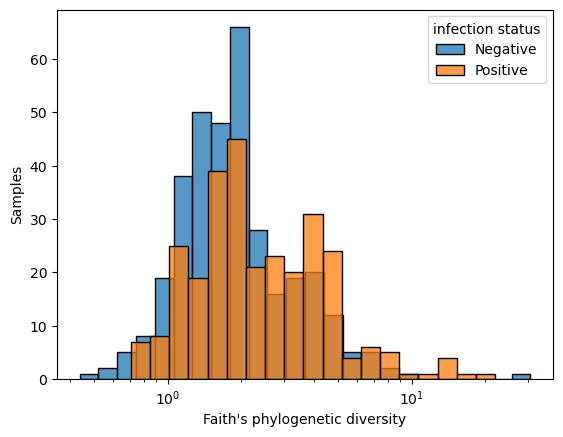

In [63]:
fig, ax = plt.subplots()
plt.xscale('log')
sns.histplot(data = bombusMeta[bombusMeta['Positive'] ==0], x = 'faithpd', 
            label = 'Negative')
sns.histplot(data = bombusMeta[bombusMeta['Positive'] ==1], x = 'faithpd', 
            label = 'Positive', bins = 19)
plt.xlabel("Faith's phylogenetic diversity")
plt.ylabel("Samples")
plt.legend(title = 'infection status')
fig.savefig('figs/faith_pd.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')

In [393]:
%%R 
library(phyr)
library(ape)
bombustree <- ape::read.tree('../data/tree')
writedir <-'crithidia_results/'


run_model <- function(taxa, model='Pos', prefix='genus'){
    # create dataframe
    tdf<-df[which(df$taxa==t),]
    tdf$log_days <-log(tdf$days_Since_May1)
    if(model=='infection_strength'){
        tdf <-tdf[which(tdf$CBombiConc>0),]
        }
    # run model 
    if(model=='infection_strength'){
        full_pglmm <- pglmm(log_ra ~ days_Since_May1 + log_CBombi + (1|sp__) + (1|site_year),
      data = tdf,family = "gaussian",cov_ranef = list(sp=bombustree), 
                        verbose = FALSE )
        }
    else{
        full_pglmm <- pglmm(log_ra ~ days_Since_May1 + Positive + (1|sp__) + (1|site_year),
      data = tdf,family = "gaussian",cov_ranef = list(sp=bombustree), 
                        verbose = FALSE )
        }
    # write results
    if (!is.null(full_pglmm)) {
        if(model=='infection_strength'){
            sink(paste0(writedir, prefix, '.',  taxa, '.strength.txt'))
            }
        else{
            sink(paste0(writedir, prefix, '.', taxa, '.txt'))
            }
        summary(full_pglmm)
        LRTs <- sapply(1:4, FUN = function(x) phyr::pglmm_profile_LRT(full_pglmm, re.number = x))
        colnames(LRTs) <- names(full_pglmm$ss)
        print(t(LRTs))
        sink()
        }
    }

# df <- read.csv('crithidia_results/df.tsv',
#                sep ='\t', row.names=1)
# for (t in unique(df$taxa)){
#     run_model(t, prefix='genus')
#     }
                       
# df <- read.csv('crithidia_results/df_3.tsv',
#                sep ='\t', row.names=1)
# for (t in unique(df$taxa)){
#     run_model(t, prefix='class')
#     }

df <- read.csv('crithidia_results/df_pos.tsv',
               sep ='\t', row.names=1)
for (t in unique(df$taxa)){
    run_model(t, 'infection_strength', prefix='genus')
    }
                       
df <- read.csv('crithidia_results/df3_pos.tsv',
               sep ='\t', row.names=1)
for (t in unique(df$taxa)){
    run_model(t, 'infection_strength', prefix='class')
    }

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: 'as(<matrix>, "dgTMatrix")' is deprecated.
Use 'as(as(as(., "dMatrix"), "generalMatrix"), "TsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the variable sp

R[write to console]: Warning:
R[write to console]:  Drop species from the phylogeny that are not in the v

## read in 

In [47]:
res=['1|sp', '1|sp__', '1|site_year', 'residual']
restats = ['Variance', 'LRT Pvalue']
fes= {'positive':['(Intercept)', 'days_Since_May1', 'Positive'],
      'load':['(Intercept)', 'days_Since_May1', 'log_CBombi']}
stats= ['Value','Std.Error','Zscore','Pvalue']


dfs = {'positive':pd.DataFrame(columns = ['level'] +\
        [a for b in [[" ".join([a,b]) for b in restats] for a in res] for a in b] + \
            [a for b in [[" ".join([a,b]) for b in stats] for a in fes['positive']] for a in b]),
       'load':pd.DataFrame(columns = ['level'] +\
        [a for b in [[" ".join([a,b]) for b in restats] for a in res] for a in b] + \
            [a for b in [[" ".join([a,b]) for b in stats] for a in fes['load']] for a in b])}

for f in [os.path.join('crithidia_results', f) for f in os.listdir('crithidia_results') \
          if not f.startswith('df')]:
    if 'strength' in f:
        df = dfs['load']
        fe = fes['load']
    else:
        df = dfs['positive']
        fe = fes['positive']
        
    name = f.split('/')[1].split(';')
    level = name[0].split('.')[0]
    
    if 'other' in name:
        name ='other'
        
    else:
        name = list(map(lambda x: x.replace(level+'.', '').replace('.txt',
                '').replace('.strength',''), name))
        for i in range(len(name)):
            if len(name[i]) <= 3:
                i = i-1
                break
        name = "-".join([level] +name[np.max([i-1,0]):i+1])

    df.loc[name, 'level']=level

    with open(f, 'r') as fin:
        for line in fin.read().split('\n'):
            if any(r in line for r in res):
                if df.loc[name, line.split()[0]+' Variance'] >=0:
                    df.loc[name, line.split()[0]+' LRT Pvalue'] = float(line.split()[3])
                else:
                    df.loc[name, line.split()[0]+' Variance'] = float(line.split()[1])
            elif any(line.startswith(f) for f in fe):
                df.loc[name, [" ".join([line.split()[0],
            b]) for b in stats]]= list(map( lambda x: 0 if '<' in x else float(x),
                                line.split()[1:5]))

for df in dfs:
    for c in dfs[df].columns:
        if 'Pvalue' in c:
            for l in dfs[df]['level'].unique():
                dfs[df].loc[dfs[df][dfs[df]['level']==l].index,c.replace('Pvalue', 'bh')] = \
                sm.stats.multipletests(dfs[df].loc[dfs[df][dfs[df]['level']==l].index,c],
                       method = 'fdr_bh', is_sorted=False,
                       returnsorted=False, alpha=0.1)[1]

In [48]:
dfs['positive'][dfs['positive']['level']=='class'].to_csv('temp.tsv', sep = '\t')

**add relative abundance**

In [49]:
def getname(name,level='genus'):
    name = name.split(';')
    for i in range(len(name)):
        if len(name[i]) <= 3:
            i = i-1
            break
    name = "-".join([level] +name[np.max([i-1,0]):i+1])
    return name

ras = pd.DataFrame(columns = ['mean ra', 'prevalence'])
prev_cut=0.1
for table, level  in zip([taxa_6_norm, taxa_3_norm], ['genus', 'class']):
    passing_taxa = table.apply(lambda x: x>0).sum()[\
    table.apply(lambda x: x>0).sum() >prev_cut*table.shape[0]].index
    temp = table[passing_taxa].copy()
    temp['other'] = 1 - temp.sum(axis=1)
    temp = pd.DataFrame({'mean ra': temp.mean(),
                         'prevalence':(temp>0).sum() / temp.shape[0]})
    temp.index = list(map(lambda x: getname(x, level), temp.index))
    ras = pd.concat([ras,temp ])  
dfs['positive'] = dfs['positive'].join(ras)
dfs['load'] = dfs['load'].join(ras)

In [50]:
dfs['positive'][(dfs['positive']['days_Since_May1 bh'] < 0.05)&\
(dfs['positive']['level'] =='genus')\
][['level','mean ra','prevalence','days_Since_May1 Value',
   'days_Since_May1 bh']].sort_values(by='mean ra',
                                      ascending=False)['mean ra'].sum()

0.42058634278917617

In [31]:
dfs['positive'][['1|sp__ Variance', '1|site_year Variance']]

,1|sp__ Variance,1|site_year Variance
1|sp__ Variance,1.000000,-0.048883
1|site_year Variance,-0.048883,1.000000


In [397]:
dfs['positive'][(dfs['positive']['days_Since_May1 bh'] < 0.05)&\
(dfs['positive']['level'] =='class') & (dfs['positive']['Positive bh'] < 10)\
][['level','mean ra','prevalence','days_Since_May1 Value',
   'days_Since_May1 bh']].sort_values(by='days_Since_May1 Value',ascending=False)

,level,mean ra,prevalence,days_Since_May1 Value,days_Since_May1 bh
class-p__Firmicutes-c__Bacilli,class,0.033304,0.822884,0.036911,0.0
class-p__Bacteroidota-c__Bacteroidia,class,0.029274,0.562696,0.016983,0.0383
class-p__Cyanobacteria-c__Cyanobacteriia,class,0.003977,0.476489,-0.045184,0.0


In [72]:
dfs['load'][dfs['load']['level']!='genus'][['mean ra', 'prevalence','1|sp Variance', 
    '1|sp LRT Pvalue', '1|sp LRT bh','1|sp__ Variance', '1|sp__ LRT Pvalue',
    '1|sp__ LRT bh','1|site_year Variance', '1|site_year LRT Pvalue', '1|site_year LRT bh',
    'residual Variance','(Intercept) Value', '(Intercept) Std.Error', '(Intercept) Zscore',
'(Intercept) Pvalue','days_Since_May1 Value', 'days_Since_May1 Std.Error',
       'days_Since_May1 Zscore', 'days_Since_May1 Pvalue', 'days_Since_May1 bh',
    'log_CBombi Value','log_CBombi Std.Error', 'log_CBombi Zscore', 'log_CBombi Pvalue',
        'log_CBombi bh']].sort_values(by='mean ra', ascending=False).to_csv('severity_res.tsv',
                                                                            sep='\t')

In [60]:
dfs['load'][dfs['load']['log_CBombi bh'] < 0.1][['log_CBombi bh',
                            'log_CBombi Value']].sort_values(by = 'log_CBombi Value')

,log_CBombi bh,log_CBombi Value
genus-f__Orbaceae-g__Gilliamella,0.0001,-0.303631
genus-f__Weeksellaceae-g__Apibacter,0.000191,-0.292272
class-p__Bacteroidota-c__Bacteroidia,0.000626,-0.276165
genus-f__Orbaceae-g__Candidatus_Schmidhempelia,0.02107,-0.20989
genus-f__Neisseriaceae-g__Snodgrassella,0.061487,-0.166029
genus-o__Orbales-f__Orbaceae,0.024904,-0.126201
class-p__Proteobacteria-c__Alphaproteobacteria,0.025986,0.195853
genus-f__Pseudomonadaceae-g__Pseudomonas,0.0,0.487089
class-other,0.025986,0.814366


In [54]:
dfs['positive']['host_scaled'] = dfs['positive']['1|sp__ Variance'].astype(float)/ \
                        dfs['positive']['mean ra'].astype(float)
dfs['positive']['site_scaled'] = dfs['positive']['1|site_year Variance'].astype(float)/ \
                        dfs['positive']['mean ra'].astype(float)
dfs['positive'][['host_scaled', 'site_scaled']].corr(method ='spearman')

,host_scaled,site_scaled
host_scaled,1.000000,0.399939
site_scaled,0.399939,1.000000


In [55]:
dfs['positive']['host_site_ratio'] = dfs['positive']['1|sp__ Variance'] / \
                dfs['positive']['1|site_year Variance']

In [56]:
dfs['positive'][dfs['positive']['Positive bh'] < 0.2][['host_site_ratio',
                            'Positive Value']].astype(float).corr(method ='spearman')

,host_site_ratio,Positive Value
host_site_ratio,1.000000,-0.187879
Positive Value,-0.187879,1.000000


In [57]:
dfs['positive'][(dfs['positive']['days_Since_May1 bh'] < 0.05)&\
(dfs['positive']['level'] =='class')\
][['level','mean ra','prevalence','days_Since_May1 Value',
   'days_Since_May1 bh']]

,level,mean ra,prevalence,days_Since_May1 Value,days_Since_May1 bh
class-p__Cyanobacteria-c__Cyanobacteriia,class,0.003977,0.476489,-0.045184,0.0
class-p__Bacteroidota-c__Bacteroidia,class,0.029274,0.562696,0.016983,0.0383
class-p__Firmicutes-c__Bacilli,class,0.033304,0.822884,0.036911,0.0


In [68]:
dfs['positive'][dfs['positive']['level']=='genus'][['mean ra']].sort_values(by='mean ra')

,mean ra
genus-d__Eukaryota-p__Ascomycota,0.000037
genus-d__Eukaryota,0.000078
genus-f__Beijerinckiaceae-g__Methylobacterium-Methylorubrum,0.000092
genus-f__Enterobacteriaceae-g__Escherichia-Shigella,0.000160
genus-f__Cellulomonadaceae-g__Cellulomonas,0.000171
genus-o__Rhizobiales-f__Rhizobiaceae,0.000201
genus-f__Propionibacteriaceae-g__Cutibacterium,0.000215
genus-f__Microbacteriaceae-g__Leifsonia,0.000291
genus-o__Bifidobacteriales-f__Bifidobacteriaceae,0.000483
genus-f__Oxalobacteraceae-g__Massilia,0.000503


In [69]:
df

'load'

In [60]:
plotdf.sort_values(by='days_Since_May1 Value', ascending=False)

,level,average relative abundance,prevalence,days_Since_May1 Value,days_Since_May1 bh,days_Since_May1 Pvalue,month change,Class
genus-other,genus,2.191333,0.799373,0.082267,0.001158,0.000475,2.303476,other
genus-f__Leuconostocaceae-g__Fructobacillus,genus,1.100155,0.526646,0.054865,0.0,0,1.536228,Bacilli
genus-o__Acetobacterales-f__Acetobacteraceae,genus,0.485227,0.304075,0.051514,0.0,0,1.442389,Alphaproteobacteria
genus-f__Leuconostocaceae-g__Leuconostoc,genus,0.521927,0.181818,0.041224,0.0,0,1.154269,Bacilli
genus-f__Erwiniaceae-g__Rosenbergiella,genus,1.770688,0.311912,0.035401,0.0,0.0,0.991236,Gammaproteobacteria
genus-f__Moraxellaceae-g__Acinetobacter,genus,1.702784,0.639498,0.028382,0.000001,0.0,0.794702,Gammaproteobacteria
genus-f__Acetobacteraceae-g__Saccharibacter,genus,1.322621,0.233542,0.0276,0.0,0.0,0.772794,Alphaproteobacteria
genus-f__Bifidobacteriaceae-g__Bifidobacterium,genus,0.382541,0.390282,0.024961,0.0,0.0,0.698908,Actinobacteria
genus-c__Gammaproteobacteria-o__Enterobacterales,genus,0.687470,0.322884,0.020649,0.000027,0.00001,0.578183,Gammaproteobacteria
genus-f__Acetobacteraceae-g__Asaia,genus,0.286641,0.114420,0.01863,0.0,0.0,0.521648,Alphaproteobacteria


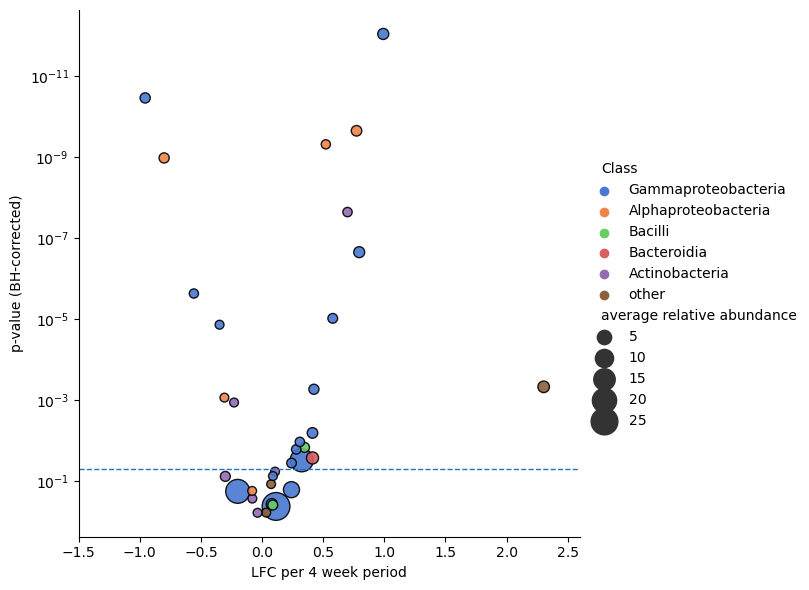

In [58]:
plotdf = dfs['positive'][(dfs['positive']['level'] =='genus')\
][['level','mean ra','prevalence','days_Since_May1 Value',
   'days_Since_May1 bh', 'days_Since_May1 Pvalue']].sort_values(by='prevalence',ascending=False)
plotdf['month change']=plotdf['days_Since_May1 Value'] * 28
plotdf['mean ra'] = plotdf['mean ra'] * 100
plotdf.rename(columns = {'mean ra': 'average relative abundance'}, inplace = True)
plotdf['Class'] =plotdf.rename(dict(zip(list(map(getname, taxa_6.columns)),
    list(map(lambda x: [a for a in x.split('o__')[0].split(';') if len(a)>4][-1].strip(';'),
             taxa_6.columns))))).index
plotdf['Class'].replace({'genus-other':'other','c__Actinobacteria':'Actinobacteria',
                         'c__Bacilli':'Bacilli','c__Gammaproteobacteria': 'Gammaproteobacteria',
        'c__Cyanobacteriia':'other','c__Bacteroidia':'Bacteroidia',
          'c__Alphaproteobacteria':'Alphaproteobacteria', 'Unassigned':'other' ,'d__Eukaryota':'other',
            'p__Ascomycota':'other'},inplace=True)             

# sns.scatterplot(data = plotdf,
#                 x= 'month change', y = 'days_Since_May1 Pvalue',
#                s = (plotdf['mean ra'])*700+2, edgecolor='black',
#                linewidth=.5)

fig= sns.relplot(x="month change", y="days_Since_May1 Pvalue",size="average relative abundance",
            sizes=(40, 400), alpha=.9, edgecolor='black',hue='Class',palette='muted',
            height=6, data=plotdf, linewidth=1, hue_order=[ 'Gammaproteobacteria','Alphaproteobacteria',
                        'Bacilli','Bacteroidia',
                           'Actinobacteria', 'other'] )


plt.yscale('log')
plt.xlim(-1.5,2.6)
plt.gca().invert_yaxis()
plt.axhline(0.05, linestyle = '--', linewidth=1)
plt.xlabel('LFC per 4 week period')
plt.ylabel('p-value (BH-corrected)')
plt.show()
fig.savefig('figs/dayosummer_volcano.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')

In [939]:
dfs['positive'].loc['genus-f__Bifidobacteriaceae-g__Bifidobacterium',
'days_Since_May1 bh']

8.051727272727273e-08

In [936]:
dfs['positive'][dfs['positive']['days_Since_May1 bh'] < 0.05\
].sort_values(by='days_Since_May1 bh')[['level', 'mean ra','days_Since_May1 bh', 'days_Since_May1 Value']]

,level,mean ra,days_Since_May1 bh,days_Since_May1 Value
class-p__Cyanobacteria-c__Cyanobacteriia,class,0.003977,0.0,-0.045184
genus-o__Acetobacterales-f__Acetobacteraceae,genus,0.004852,0.0,0.051514
genus-f__Chloroplast-g__Chloroplast,genus,0.003975,0.0,-0.045147
genus-f__Rhizobiaceae-g__Ochrobactrum,genus,0.040464,0.0,-0.049973
genus-f__Leuconostocaceae-g__Leuconostoc,genus,0.005219,0.0,0.041224
genus-f__Leuconostocaceae-g__Fructobacillus,genus,0.011002,0.0,0.054865
genus-f__Erwiniaceae-g__Rosenbergiella,genus,0.017707,0.0,0.035401
class-p__Firmicutes-c__Bacilli,class,0.033304,0.0,0.036911
genus-f__Xanthomonadaceae-g__Stenotrophomonas,genus,0.010788,0.0,-0.034142
genus-f__Acetobacteraceae-g__Saccharibacter,genus,0.013226,0.0,0.0276


In [949]:
dfs['positive'][dfs['positive']['1|sp__ LRT bh'] < 0.05][['1|sp__ LRT bh','1|site_year Variance',
                            'level', '1|sp__ Variance', 'mean ra']].sort_values(by='1|sp__ Variance').corr()

/var/folders/hd/67t7954n4_bd9_fw90jxq_l00000gp/T/ipykernel_4084/2309418843.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfs['positive'][dfs['positive']['1|sp__ LRT bh'] < 0.05][['1|sp__ LRT bh','1|site_year Variance',


,mean ra
mean ra,1.0


In [926]:
dfs['positive'][dfs['positive']['Positive bh'] < 0.1][['Positive Value', 
                                    'Positive Pvalue','Positive bh']]

,Positive Value,Positive Pvalue,Positive bh
genus-f__Hafniaceae-g__Hafnia-Obesumbacterium,0.927767,0.000169,0.00329
genus-f__Orbaceae-g__Gilliamella,-0.679349,0.004829,0.06125
class-p__Bacteroidota-c__Bacteroidia,-0.752767,0.01396,0.0698
class-other,4.043916,0.000409,0.00409
genus-f__Weeksellaceae-g__Apibacter,-0.823632,0.006282,0.06125
genus-f__Pseudomonadaceae-g__Pseudomonas,1.077249,0.000059,0.002291
class-p__Proteobacteria-c__Gammaproteobacteria,0.125884,0.024427,0.081423


In [927]:
plotdf = dfs['positive'][(dfs['positive']['level'] =='genus')][['mean ra','1|sp__ Variance',
                 '1|site_year Variance', '1|site_year LRT bh',
                '1|sp__ LRT bh']].astype(float).copy()
plotdf.rename(columns = {'mean ra': 'average relative abundance'}, inplace = True)
      

In [928]:
plotdf = dfs['positive'][(dfs['positive']['level'] =='genus')][['1|sp__ LRT bh',
        '1|sp__ Variance']].rename(columns = {'1|sp__ LRT bh': 'p-value (corrected)',
        '1|sp__ Variance': 'Variance'})
plotdf['variable'] = 'species'
plotdf =pd.concat([plotdf, dfs['positive'][(dfs['positive']['level'] =='genus')][['1|site_year LRT bh',
        '1|site_year Variance']].rename(columns = {'1|site_year LRT bh': 'p-value (corrected)',
        '1|site_year Variance':'Variance'})])
plotdf['variable'].fillna('site', inplace=True)
plotdf = plotdf.join(dfs['positive']['mean ra'])

plotdf['Class'] =plotdf.rename(dict(zip(list(map(getname, taxa_6.columns)),
    list(map(lambda x: [a for a in x.split('o__')[0].split(';') if len(a)>4][-1].strip(';'),
             taxa_6.columns))))).index
plotdf['Class'].replace({'genus-other':'other','c__Actinobacteria':'other',
                         'c__Bacilli':'Bacilli','c__Gammaproteobacteria': 'Gammaproteobacteria',
        'c__Cyanobacteriia':'Cyanobacteriia','c__Bacteroidia':'Bacteroidia',
          'c__Alphaproteobacteria':'other',   'Unassigned':'other' ,'d__Eukaryota':'other',
            'p__Ascomycota':'other'},inplace=True)  

plotdf['size'] = plotdf['mean ra'].transform(np.sqrt) 
plotdf['size'] = 250/plotdf['size'].max() * plotdf['size']

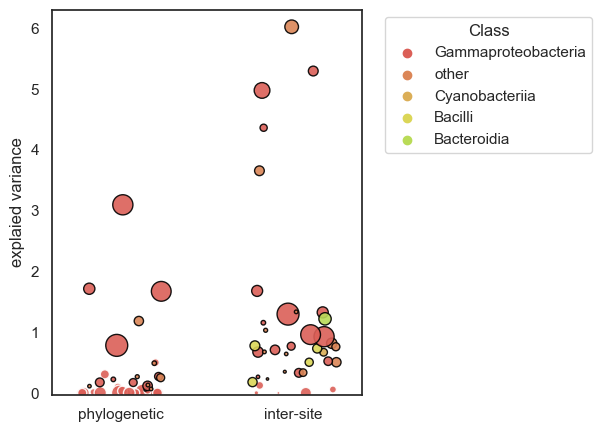

In [929]:
fig, ax = plt.subplots(figsize = (4,5))
plotdf['x'] = plotdf['variable'].replace({'species':0, 'site':1}).apply(lambda x: x+np.random.uniform(-.25,.25))
sns.scatterplot(data = plotdf[plotdf['p-value (corrected)'] >= 0.05],
            x = 'x',y='Variance', s = plotdf[plotdf['p-value (corrected)'] >= 0.05]['size'],
               edgecolor='white', alpha =0.9, linewidth=1)
sns.scatterplot(data = plotdf[plotdf['p-value (corrected)'] < 0.05],
            x = 'x',y='Variance', s = plotdf[plotdf['p-value (corrected)'] < 0.05]['size'],
               edgecolor='black', alpha =0.9, linewidth=1, hue = 'Class')
plt.ylim(-.03, 6.3)
plt.xlim(-.4,1.4)
plt.xticks([0,1], ['phylogenetic', 'inter-site'])
plt.ylabel('explaied variance')
plt.xlabel(None)
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1.05,1))

In [950]:
plotdf = dfs['positive'][dfs['positive']['level']=='genus'][['1|sp__ LRT bh',
        '1|sp__ Variance', '1|site_year LRT bh','1|site_year Variance', 
                                                            'mean ra']].copy()
plotdf['size'] = plotdf['mean ra'].transform(np.sqrt) 
plotdf['size'] = 240/plotdf['size'].max() * plotdf['size'] +15

plotdf['Class'] =plotdf.rename(dict(zip(list(map(getname, taxa_6.columns)),
    list(map(lambda x: [a for a in x.split('o__')[0].split(';') if len(a)>4][-1].strip(';'),
             taxa_6.columns))))).index
plotdf['Class'].replace({'genus-other':'other','c__Actinobacteria':'Actinobacteria',
                         'c__Bacilli':'Bacilli','c__Gammaproteobacteria': 'Gammaproteobacteria',
        'c__Cyanobacteriia':'other','c__Bacteroidia':'Bacteroidia',
          'c__Alphaproteobacteria':'Alphaproteobacteria',   'Unassigned':'other' ,'d__Eukaryota':'other',
            'p__Ascomycota':'other'},inplace=True)

In [953]:
plotdf['mean_scaled_sp_var'] = plotdf['1|sp__ Variance'] / \
                                plotdf['mean ra']
plotdf['mean_scaled_site_var'] = plotdf['1|site_year Variance'] / \
                                plotdf['mean ra']

In [954]:
plotdf[plotdf['1|sp__ LRT bh'] <=0.05]['Class'].unique()

array(['Actinobacteria', 'Gammaproteobacteria', 'Alphaproteobacteria',
       'other'], dtype=object)

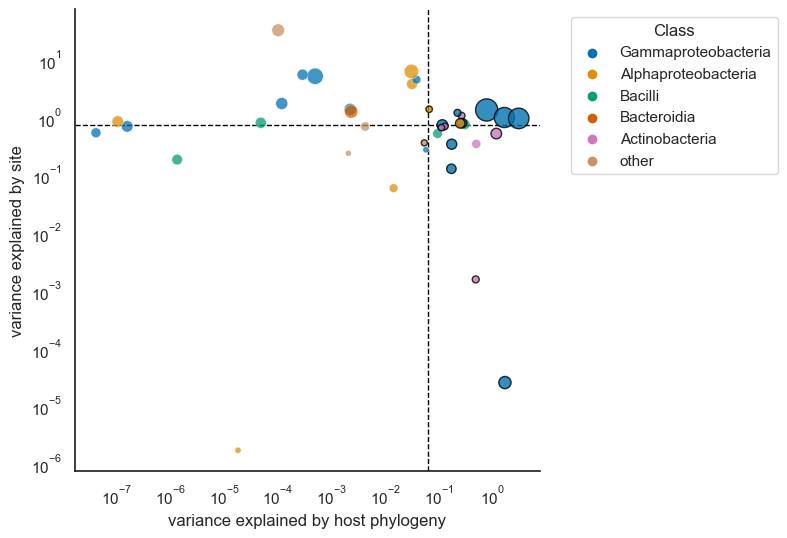

In [961]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data = plotdf[plotdf['1|sp__ LRT bh'] >0.05], x = '1|sp__ Variance', 
                y = '1|site_year Variance', s = plotdf[plotdf['1|sp__ LRT bh'] >0.05]['size'],
               hue = 'Class', legend =False, alpha=0.75,palette='colorblind',
               hue_order = [ 'Gammaproteobacteria','Alphaproteobacteria','Bacilli','Bacteroidia',
                           'Actinobacteria', 'other'])
sns.scatterplot(data = plotdf[plotdf['1|sp__ LRT bh'] <=0.05], x = '1|sp__ Variance', 
                y = '1|site_year Variance', s = plotdf[plotdf['1|sp__ LRT bh'] <=0.05]['size'],
               edgecolor='black',linewidth=1, color ='C0', hue = 'Class', alpha =0.8,
               palette='colorblind',
               hue_order = [ 'Gammaproteobacteria','Alphaproteobacteria','Bacilli','Bacteroidia',
                           'Actinobacteria', 'other'])
plt.xscale('log')
plt.yscale('log')
plt.axvline(6.203000e-02, linestyle='--', linewidth=1,zorder=-1, color='black')
plt.axhline(7.204000e-01, linestyle='--', linewidth=1,zorder=-1, color ='black')
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1.05,1))
sns.despine()
plt.ylabel('variance explained by site')
plt.xlabel('variance explained by host phylogeny')

plt.savefig('figs/variance_scatter.pdf',
               format = 'pdf', transparent = True, bbox_inches='tight')

In [478]:
bombusMeta[bombusMeta['Positive']==1]['CBombiConc'].mean()

14696.410474785906

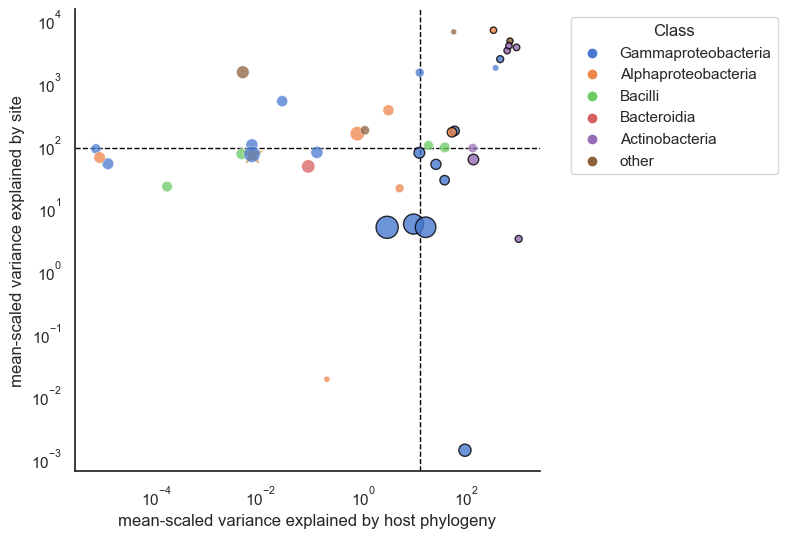

In [994]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data = plotdf[plotdf['1|sp__ LRT bh'] >0.05], x = 'mean_scaled_sp_var', 
                y = 'mean_scaled_site_var', s = plotdf[plotdf['1|sp__ LRT bh'] >0.05]['size'],
               hue = 'Class', legend =False, alpha=0.75,palette='muted',
               hue_order = [ 'Gammaproteobacteria','Alphaproteobacteria','Bacilli','Bacteroidia',
                           'Actinobacteria', 'other'])
sns.scatterplot(data = plotdf[plotdf['1|sp__ LRT bh'] <=0.05], x = 'mean_scaled_sp_var', 
                y = 'mean_scaled_site_var', s = plotdf[plotdf['1|sp__ LRT bh'] <=0.05]['size'],
               edgecolor='black',linewidth=1, color ='C0', hue = 'Class', alpha =0.8,
               palette='muted',
               hue_order = [ 'Gammaproteobacteria','Alphaproteobacteria','Bacilli','Bacteroidia',
                           'Actinobacteria', 'other'])
plt.xscale('log')
plt.yscale('log')
plt.axvline(plotdf['mean_scaled_sp_var'].median(), linestyle='--', linewidth=1,zorder=-1, color='black')
plt.axhline(plotdf['mean_scaled_site_var'].median(), linestyle='--', linewidth=1,zorder=-1, color ='black')
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1.05,1))
sns.despine()
plt.ylabel('mean-scaled variance explained by site')
plt.xlabel('mean-scaled variance explained by host phylogeny')

plt.scatter(x=[0.006979446538395483], y=[69.96828482882157], marker = "*",s = 200, zorder = -1)
# plt.savefig('figs/mean_scaled_variance_scatter.pdf',
#                format = 'pdf', transparent = True, bbox_inches='tight')

In [26]:
[x for x in dfs['positive'].index if 'Bif' in x]

['genus-f__Bifidobacteriaceae-g__Bombiscardovia',
 'genus-o__Bifidobacteriales-f__Bifidobacteriaceae',
 'genus-f__Bifidobacteriaceae-g__Bifidobacterium']

In [27]:
dfs['positive'].loc['genus-o__Bifidobacteriales-f__Bifidobacteriaceae']

level                             genus
1|sp Variance                  0.000016
1|sp LRT Pvalue                     1.0
1|sp__ Variance                  0.4894
1|sp__ LRT Pvalue                   0.0
1|site_year Variance           0.001508
1|site_year LRT Pvalue         0.462748
residual Variance                 1.283
residual LRT Pvalue                 1.0
(Intercept) Value             -9.938351
(Intercept) Std.Error          0.463317
(Intercept) Zscore             -21.4505
(Intercept) Pvalue                    0
days_Since_May1 Value          0.003797
days_Since_May1 Std.Error      0.002013
days_Since_May1 Zscore            1.886
days_Since_May1 Pvalue           0.0593
Positive Value                -0.023444
Positive Std.Error             0.095917
Positive Zscore                 -0.2444
Positive Pvalue                  0.8069
1|sp LRT bh                         1.0
1|sp__ LRT bh                       0.0
1|site_year LRT bh             0.487762
residual LRT bh                     1.0


In [471]:
#plotdf = dfs['positive'][dfs['positive']['level']=='genus'][['Positive Value',
#        'Positive bh','mean ra', '(Intercept) Value', 'days_Since_May1 Value']].copy()

# plotdf['size'] = plotdf['mean ra'].transform(np.sqrt) 
# plotdf['size'] = 240/plotdf['size'].max() * plotdf['size'] +15

# plotdf['Class'] =plotdf.rename(dict(zip(list(map(getname, taxa_6.columns)),
#     list(map(lambda x: [a for a in x.split('o__')[0].split(';') if len(a)>4][-1].strip(';'),
#              taxa_6.columns))))).index
# plotdf['Class'].replace({'genus-other':'other','c__Actinobacteria':'Actinobacteria',
#                          'c__Bacilli':'Bacilli','c__Gammaproteobacteria': 'Gammaproteobacteria',
#         'c__Cyanobacteriia':'other','c__Bacteroidia':'Bacteroidia',
#           'c__Alphaproteobacteria':'Alphaproteobacteria',   'Unassigned':'other' ,'d__Eukaryota':'other',
#             'p__Ascomycota':'other'},inplace=True)


taxa = dfs['positive'][(dfs['positive']['Positive bh'] < 0.1)&\
(dfs['positive']['level']=='genus')].sort_values(by='Positive Value').index
plotdf= taxa_6_norm.rename(columns = dict(zip(taxa_6.columns, 
            list(map(getname, taxa_6.columns)))))[taxa].copy()
plotdf = pd.melt(plotdf.reset_index().rename(columns = {'index':'sample'}),
           id_vars = 'sample', var_name='species', value_name='RA')
plotdf = pd.merge(plotdf,dfs['positive'][['Positive Value','Positive bh']],
         left_on='species', right_index=True)
plotdf = pd.merge(plotdf, bombusMeta[['Positive']], left_on ='sample',
         right_index=True)

In [504]:
plotdf['RA_pseudo'] = plotdf['RA'].replace(0,plotdf[plotdf['RA']>0]['RA'].min()/2)

In [472]:
dfs['positive'].loc[taxa][['Positive Value']]

,Positive Value
genus-f__Weeksellaceae-g__Apibacter,-0.823632
genus-f__Orbaceae-g__Gilliamella,-0.679349
genus-Unassigned,0.404389
genus-f__Hafniaceae-g__Hafnia-Obesumbacterium,0.927767
genus-f__Pseudomonadaceae-g__Pseudomonas,1.077249


In [526]:
plotdf[(plotdf['RA'] > 0) & \
(plotdf['RA']<.01)]['RA'].quantile(.5)

0.00041715788519089506

In [549]:
taxa = ['genus-f__Weeksellaceae-g__Apibacter','genus-f__Orbaceae-g__Gilliamella',
        'genus-f__Pseudomonadaceae-g__Pseudomonas', 
        'genus-f__Hafniaceae-g__Hafnia-Obesumbacterium']
        

In [528]:
plotdf['RA_pseudo'] = plotdf['RA'].apply(lambda x: x if x>0.005 else 0.005)

In [649]:
order = {'genus-f__Orbaceae-g__Gilliamella': 0,
         'genus-f__Weeksellaceae-g__Apibacter':1,
         'genus-f__Pseudomonadaceae-g__Pseudomonas':2,
         'genus-f__Hafniaceae-g__Hafnia-Obesumbacterium':3,
         'genus-Unassigned':4}
plotdf['order'] = plotdf['species'].replace(order)
plotdf.sort_values(by='order',inplace=True)

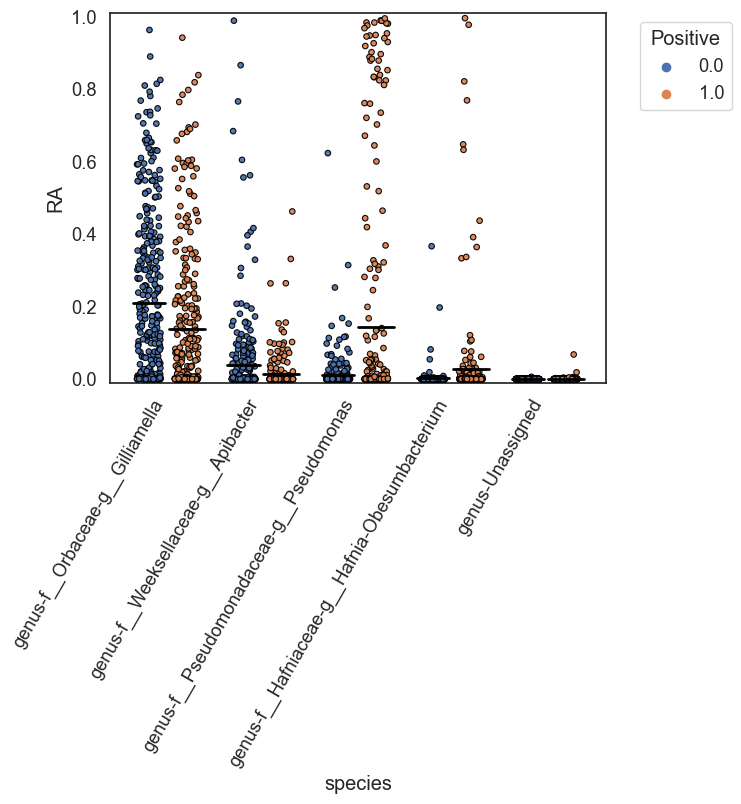

In [655]:
fig,ax =plt.subplots()
#plt.yscale('log')
# sns.violinplot(data = plotdf, x = 'species', y= 'RA',
#              hue = 'Positive', cut=0, linewidth=1 )
sns.stripplot(data = plotdf, x = 'species', y= 'RA',
              hue = 'Positive', dodge=True, s = 4, edgecolor='black', linewidth=.8,
             jitter = 0.25, alpha = 0.95)
plt.xticks(rotation=60, ha='right')
sns.move_legend(ax, loc = 'upper left', bbox_to_anchor=(1.05,1))

for i in range(len(plotdf['species'].unique())):
    s=plotdf['species'].unique()[i]
    mean=plotdf[(plotdf['species']==s) & (plotdf['Positive']==0)]['RA'].mean()
    plt.plot([i-.37, i-.03], [mean,mean], zorder=3,linewidth=2, color ='black')
    mean=plotdf[(plotdf['species']==s) & (plotdf['Positive']==1)]['RA'].mean()
    plt.plot([i+.01,i+.39], [mean,mean], zorder=3,linewidth=2, color ='black')


# plt.xlim(-.5,.5)
# plt.axvline(-.33)
# plt.axvline(-.07)
plt.ylim(-0.01, 1.01)
plt.show()

## Severity

In [409]:
comparedf = dfs['positive'][['mean ra', 'prevalence','level','Positive Value',
    'Positive bh']].join(dfs['load'][['log_CBombi bh', 'log_CBombi Pvalue',
                'log_CBombi Value']]).copy()
comparedf['log_CBombi bh'].fillna(1, inplace=True)
comparedf['log_CBombi Value'].fillna(0, inplace=True)

In [410]:
comparedf.isna().sum()

mean ra              0
prevalence           0
level                0
Positive Value       0
Positive bh          0
log_CBombi bh        0
log_CBombi Pvalue    2
log_CBombi Value     0
dtype: int64

In [411]:
comparedf[['log_CBombi bh', 'Positive bh']].min().min()

1.3111999999999999e-08

In [412]:
1/comparedf[['log_CBombi bh', 'Positive bh']].max().max()

1.0

In [413]:
comparedf['severity_size'] = 1/comparedf['log_CBombi bh']
comparedf['severity_size'] = (comparedf['severity_size'] - 1.00775) / \
                            (1/0.05 - 1) * 400 + 20
comparedf['severity_size'] = comparedf['severity_size'].apply(lambda x: np.log(x-450) + 450 if x>450 else x)

comparedf['pos_size'] = 1/comparedf['Positive bh']
comparedf['pos_size'] = (comparedf['pos_size'] - 1.00775) / \
                            (1/0.05 - 1) * 400 + 20
comparedf['pos_size'] = comparedf['pos_size'].apply(lambda x: np.log(x-450) + 450 if x>450 else x)

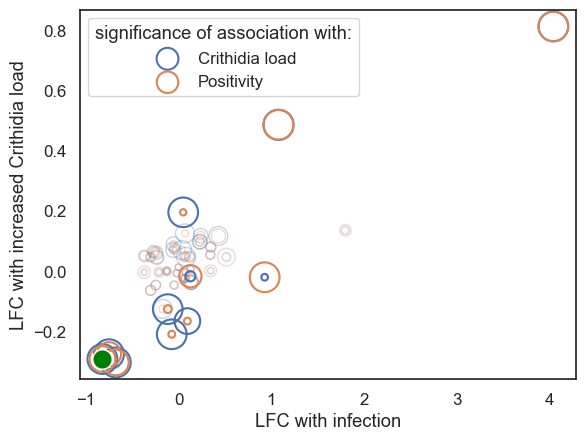

In [427]:
fig,ax = plt.subplots()
plotdf = comparedf[(comparedf['Positive bh'] < 0.1) | (comparedf['log_CBombi bh'] < 0.1)]

plotdf2 = comparedf[(comparedf['Positive bh'] > 0.1) | (comparedf['log_CBombi bh'] > 0.1)]

sns.scatterplot(data = plotdf2, x = 'Positive Value', y = 'log_CBombi Value', 
           s = plotdf2['severity_size'], edgecolor = 'C0', color = 'none',
               linewidth=1, alpha = 0.3)

sns.scatterplot(data = plotdf2, x = 'Positive Value', y = 'log_CBombi Value', 
           s = plotdf2['pos_size'], edgecolor = 'C1', color = 'none',
               linewidth=1, alpha = 0.3)

sns.scatterplot(data = plotdf, x = 'Positive Value', y = 'log_CBombi Value', 
           s = plotdf['severity_size'], edgecolor = 'C0', color = 'none',
               linewidth=1.5, label = 'Crithidia load')

sns.scatterplot(data = plotdf, x = 'Positive Value', y = 'log_CBombi Value', 
           s = plotdf['pos_size'], edgecolor = 'C1', color = 'none',
               linewidth=1.5, label = 'Positivity')

sns.scatterplot(data = plotdf.loc[['genus-f__Weeksellaceae-g__Apibacter']],
                 x = 'Positive Value', y = 'log_CBombi Value', color ='green',
               s = 200)

plt.xlabel('LFC with infection')
plt.ylabel('LFC with increased Crithidia load')
plt.legend(title = 'significance of association with:')
# plt.savefig('figs/severity_scatter.pdf',
#                format = 'pdf', transparent = True, bbox_inches='tight')

In [487]:
taxa_6_norm.sum()[taxa_6_norm.sum() >0]

Unassigned;__;__;__;__;__                                                                                               0.158938
d__Archaea;p__Crenarchaeota;c__Nitrososphaeria;o__Nitrosopumilales;f__Nitrosopumilaceae;g__Candidatus_Nitrosopumilus    0.000076
d__Archaea;p__Crenarchaeota;c__Nitrososphaeria;o__Nitrosopumilales;f__Nitrosopumilaceae;g__Nitrosopumilaceae            0.000031
d__Bacteria;__;__;__;__;__                                                                                              0.008391
d__Bacteria;p__Abditibacteriota;c__Abditibacteria;o__Abditibacteriales;f__Abditibacteriaceae;g__Abditibacterium         0.000500
                                                                                                                          ...   
d__Eukaryota;p__Ascomycota;c__Sordariomycetes;o__Xylariales;f__Xylariaceae;g__Xylariaceae                               0.000104
d__Eukaryota;p__Basidiomycota;c__Agaricomycetes;__;__;__                                         

In [496]:
taxa_6_norm[[x for x in taxa_6_norm.columns if 'Gill' in x or 'Snod' in x]].sum(axis=1).mean()

0.4500136856958954

In [ ]:
taxa_6_norm['G

In [430]:
comparedf[['log_CBombi Value',
           'Positive Value']].astype(float).corr()

,log_CBombi Value,Positive Value
log_CBombi Value,1.00000,0.80443
Positive Value,0.80443,1.00000


In [483]:
comparedf[(comparedf['Positive bh'] > 0.1) &\
(comparedf['log_CBombi bh'] < 0.1)].sort_values(by = 'mean ra',
                                               ascending =False)

,mean ra,prevalence,level,Positive Value,Positive bh,log_CBombi bh,log_CBombi Pvalue,log_CBombi Value,severity_size,pos_size
genus-f__Neisseriaceae-g__Snodgrassella,0.271640,0.982759,genus,0.093158,0.8168,0.061487,0.009223,-0.166029,341.177655,24.558735
genus-f__Orbaceae-g__Candidatus_Schmidhempelia,0.193365,0.915361,genus,-0.075164,0.8168,0.021070,0.002107,-0.209890,456.306202,24.558735
class-p__Proteobacteria-c__Alphaproteobacteria,0.080730,0.791536,class,0.048369,0.965122,0.025986,0.007087,0.195853,455.883176,20.597646
genus-o__Orbales-f__Orbaceae,0.018541,0.208464,genus,-0.118257,0.637511,0.024904,0.003113,-0.126201,455.976695,31.807391


In [229]:
comparedf[(comparedf['Positive bh'] <0.1) | (comparedf['log_CBombi bh'] < 0.1)]

,mean ra,prevalence,level,Positive Value,Positive bh,log_CBombi bh,log_CBombi Value
genus-f__Hafniaceae-g__Hafnia-Obesumbacterium,0.013658,0.253918,genus,0.927767,0.00329,0.036169,0.099169
genus-f__Orbaceae-g__Gilliamella,0.178373,0.959248,genus,-0.679349,0.06125,0.02106,-0.105228
class-p__Bacteroidota-c__Bacteroidia,0.029274,0.562696,class,-0.752767,0.0698,0.020425,-0.114833
genus-c__Gammaproteobacteria-o__Enterobacterales,0.006875,0.322884,genus,0.515116,0.129168,0.07527,0.074309
class-other,0.000685,0.434169,class,4.043916,0.00409,0.004959,0.550758
genus-f__Weeksellaceae-g__Apibacter,0.027249,0.402821,genus,-0.823632,0.06125,0.017654,-0.12652
genus-f__Pseudomonadaceae-g__Pseudomonas,0.071094,0.659875,genus,1.077249,0.002291,0.0,0.227736
genus-o__Acetobacterales-f__Acetobacteraceae,0.004852,0.304075,genus,0.427009,0.19617,0.0074,0.101355
class-p__Proteobacteria-c__Gammaproteobacteria,0.837690,1.000000,class,0.125884,0.081423,0.2406,0.012158


In [439]:
dfs['positive'][['days_Since_May1 Value'\
        ]].rename(columns = {'days_Since_May1 Value':'pos'}).join(\
dfs['load'][['days_Since_May1 Value']]).astype(float).corr()

,pos,days_Since_May1 Value
pos,1.000000,0.844648
days_Since_May1 Value,0.844648,1.000000


In [456]:
bombusMeta[bombusMeta['Positive'] ==1][['faithpd',
               'CBombiConc']].corr(method ='spearman')

,faithpd,CBombiConc
faithpd,1.000000,0.118541
CBombiConc,0.118541,1.000000


In [460]:
bombusMeta[bombusMeta['Positive'] ==1]['faithpd'].isna().sum()

5

In [466]:
scipy.stats.spearmanr(bombusMeta[bombusMeta['Positive'] ==1\
                ][['faithpd', 'CBombiConc']].dropna()['faithpd'],
np.log(bombusMeta[bombusMeta['Positive'] ==1\
                ][['faithpd', 'CBombiConc']].dropna()['CBombiConc']))


SignificanceResult(statistic=0.11854060170995996, pvalue=0.045559054503010454)

<AxesSubplot: xlabel='faithpd', ylabel='CBombiConc'>

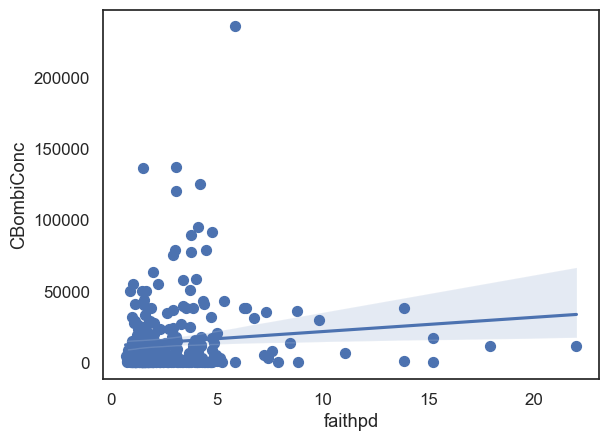

In [475]:
sns.regplot(data = bombusMeta[bombusMeta['Positive']==1],
                x = 'faithpd',
                y='CBombiConc', x_estimator=np.mean)

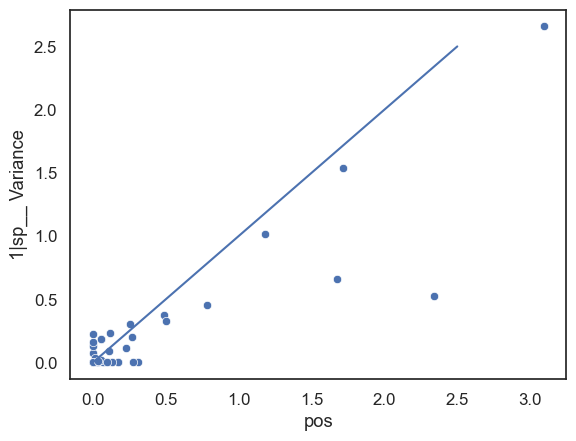

In [441]:
sns.scatterplot(data = dfs['positive'][['1|sp__ Variance'\
        ]].rename(columns = {'1|sp__ Variance':'pos'}).join(\
dfs['load'][['1|sp__ Variance']]).astype(float),x='pos',
                y = '1|sp__ Variance')
plt.plot([0,2.5], [0,2.5])

In [449]:
bombusMeta[bombusMeta['Positive']==1].shape

(290, 52)

In [446]:
df_pos['sample'].unique().shape

(290,)

In [443]:
dfs['positive'][['1|sp__ Variance'\
        ]].rename(columns = {'1|sp__ Variance':'pos'}).join(\
dfs['load'][['1|sp__ Variance']]).astype(float).sort_values(by='pos',ascending=False)

,pos,1|sp__ Variance
genus-f__Orbaceae-g__Candidatus_Schmidhempelia,3.093823e+00,2.658000e+00
class-other,2.343000e+00,5.246000e-01
genus-o__Orbales-f__Orbaceae,1.714000e+00,1.538000e+00
genus-f__Orbaceae-g__Gilliamella,1.671218e+00,6.587000e-01
genus-f__Bifidobacteriaceae-g__Bombiscardovia,1.183000e+00,1.018000e+00
genus-f__Neisseriaceae-g__Snodgrassella,7.827000e-01,4.519000e-01
genus-f__Bifidobacteriaceae-g__Bifidobacterium,5.005000e-01,3.248000e-01
genus-o__Bifidobacteriales-f__Bifidobacteriaceae,4.894000e-01,3.734000e-01
genus-f__Lactobacillaceae-g__Lactobacillus,3.068000e-01,1.353000e-04
genus-f__Erwiniaceae-g__Erwinia,2.722000e-01,1.836000e-04


# dendrogram

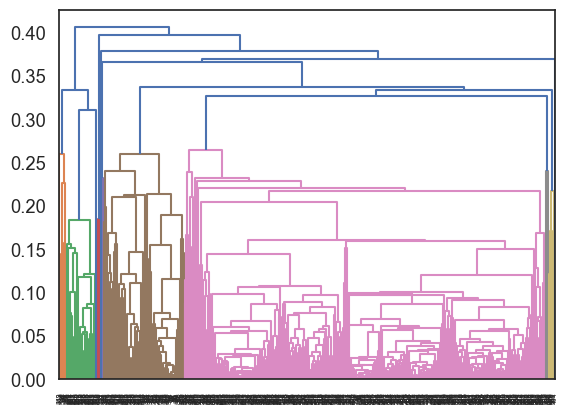

In [660]:
clusters= scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(wu_df),
                                          'average',optimal_ordering = True)
d = scipy.cluster.hierarchy.dendrogram(clusters)
index_ordered = wu_df.iloc[d['leaves']].index

In [771]:
coretaxa = [x for x in dfs['positive'].index if any( y in x for y in ['Snod', 'Gillia',
            'Lactobacillus', 'Bifidobacterium', 'Bombiscar', 'Schmid', 'Apibac',
                            'Orba'])]

ranking = pd.DataFrame(dfs['positive'][['Positive Value', 
                    'mean ra', 'prevalence']].apply(lambda x: x['mean ra']+x['prevalence'] - \
                                x['Positive Value'],axis=1).sort_values(),
                      columns = ['score'])
ranking.loc[coretaxa, 'score'] = ranking.loc[coretaxa, 'score']+.75

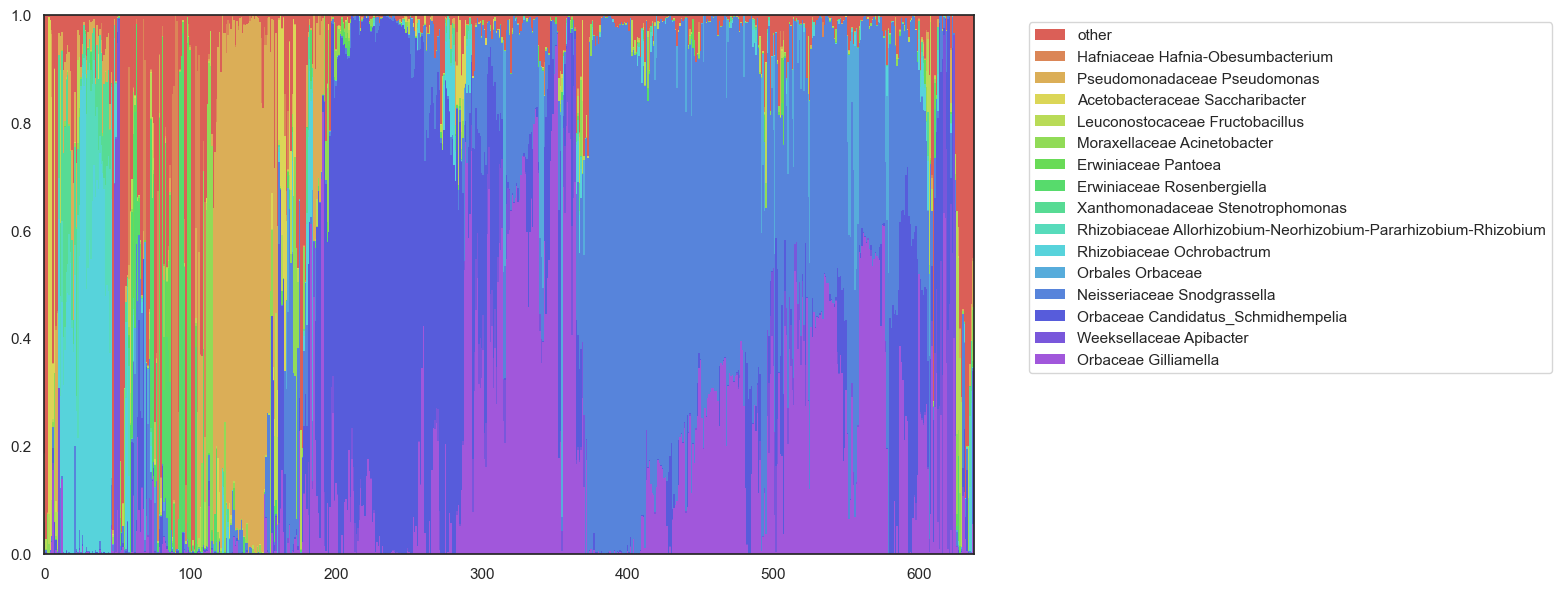

In [997]:
plotdf = taxa_6_norm.loc[index_ordered].copy()
# plotdf = plotdf.loc[[x for x in plotdf.index if x in \
#         set(np.random.choice(bombusMeta[bombusMeta['Positive']==1].index,
#                                 50)).union( \
#         set(np.random.choice(bombusMeta[bombusMeta['Positive']==0].index, 50)))]]
# #plotdf = plotdf.iloc[sorted(np.random.choice(np.arange(0,638), 100))]
plotdf.rename(columns = dict(zip(plotdf.columns, list(map(getname,plotdf.columns)))),
             inplace=True)
plotdf = plotdf[list(set(plotdf.columns).intersection(set(dfs['positive'].index)))].copy()
# sort by C. bombi association 
# plotdf = plotdf[dfs['positive'].loc[plotdf.columns].sort_values(by= 'Positive Value').index]
# plotdf = plotdf[plotdf.sum()[plotdf.sum() >=plotdf.sum().sort_values()[-15]].index].copy()

#get top ra taxa
plotdf = plotdf[plotdf.sum().sort_values(ascending = False)[:15].index]
# sort by mean ra + prev - c bombi assoc
plotdf = plotdf[ranking.loc[plotdf.columns].sort_values(by = 'score',ascending=False).index]
for i in range(1, plotdf.shape[1]):
    plotdf[plotdf.columns[i]] = plotdf[plotdf.columns[i]] + plotdf[plotdf.columns[i-1]]
plotdf['other'] =1
plotdf['x']=np.arange(len(plotdf))
plotdf = plotdf.iloc[:, ::-1] 


sns.set(style = 'white', palette = sns.color_palette("hls", 20))
fig, ax = plt.subplots(figsize = (12,7))
plotdf.columns = list(map(lambda x: x.replace('genus', '').replace('-g__',
    ' ').replace('-o__',' ').replace('-f__', ' ').strip(), plotdf.columns))
for c in range(1, plotdf.shape[1]):
    plt.bar(x = plotdf['x'], height = plotdf[plotdf.columns[c]],
           label = plotdf.columns[c], width = 1, edgecolor=None, linewidth=0)
    
# pd2 = plotdf[['x']].join(bombusMeta[['Positive', 'CBombiConc']])
# pd2 = pd2[pd2['Positive']==1]
# plt.scatter(x = pd2['x'], y = pd2['Positive'], zorder = 3, s = 40, 
#            edgecolor = 'Black',linewidths=0.1, label = 'Crithidia Positive',
#            c = pd2['CBombiConc'].transform(np.log), cmap = 'Oranges')



plt.legend(bbox_to_anchor = (1.05, 1))
plt.xlim(0, 638)
plt.ylim(0,1)
fig.savefig('taxabarplot.pdf', bbox_inches='tight', transparent=True,
           format='pdf')

In [1000]:
pd2 = plotdf[['x']].join(bombusMeta[['Positive', 'CBombiConc']])
def get_sliding_pos(center):
    window = 20
    #center =5 
    round = True
    temp = pd2[(pd2['x'] >center-window) & (pd2['x'] < center+window)].copy()
    if round:
        temp['dist'] = np.abs(temp['x'] - center)
        temp['dist'] = temp['dist'].replace(0,.1)**(-.5)
        temp['dist'] = temp['dist']  / temp['dist'].sum()
        return (temp['dist'] * temp['Positive']).sum()
    else:
        return temp['Positive'].mean()
pd2['avg_pos'] = pd2['x'].apply(get_sliding_pos)

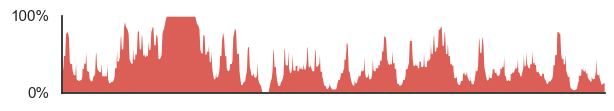

In [1001]:
fig, ax = plt.subplots(figsize = (7,1))
#sns.lineplot(data = pd2, x = 'x', y = 'avg_pos')
plt.fill_between(pd2['x'], pd2['avg_pos'])
plt.xlim(1,637)
plt.ylim(0,1)
plt.xticks([])
sns.despine(left=False, bottom=False)
plt.yticks([0,1], ['0%', '100%'])
plt.show()
fig.savefig('infection_avg.pdf', bbox_inches='tight', transparent=True,
           format='pdf')